In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import PIL
import cv2
from tensorflow.keras.layers import Dense, Input, Reshape, InputLayer, Flatten
from tensorflow.keras.models import Sequential, Model
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
IMG_WIDTH = 200
IMG_HEIGHT = 200
img_folder = "data"

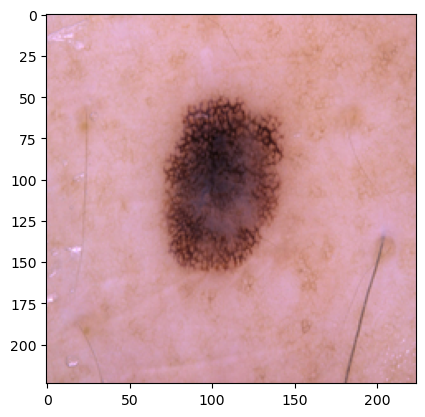

In [11]:
test_img = "data/train/benign/100.jpg"
test_img2 = "data/train/malignant/10.jpg"
img = mpimg.imread(test_img)
img2 = mpimg.imread(test_img2)
plt.imshow(img)

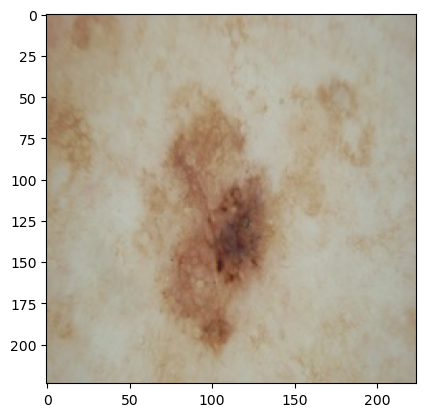

In [12]:
plt.imshow(img2)

In [16]:
def create_dataset_tf(img_folder):
    class_name = []
    tf_img_data_array = []
    
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder,dir1)):
            image = os.path.join(img_folder, dir1, file)
            image = tf.io.read_file(image)
            image = tf.io.decode_jpeg(image, channels=3)
            image = tf.image.resize(image, (200,200))
            image = tf.cast(image / 255., tf.float32)
            tf_img_data_array.append(image)
            class_name.append(dir1)
    return tf.stack(tf_img_data_array, axis=0), class_name